# Construct PyTorch Dataloaders for Cocktail Party Problem

In this notebook, we will show how to construct dataloaders for researching the `Cocktail Party Problem`.

Before you get started, please ensure you have downloaded the data following the instructions in [01_Download_Dataset](https://github.com/earthspecies/library/blob/main/macaques/01_Download_Dataset.ipynb).

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
import librosa

import soundfile as sf
import scipy.signal
from sklearn.model_selection import train_test_split

import torch
import multiprocessing

In [11]:
anno = pd.read_csv('data/annotations.csv')

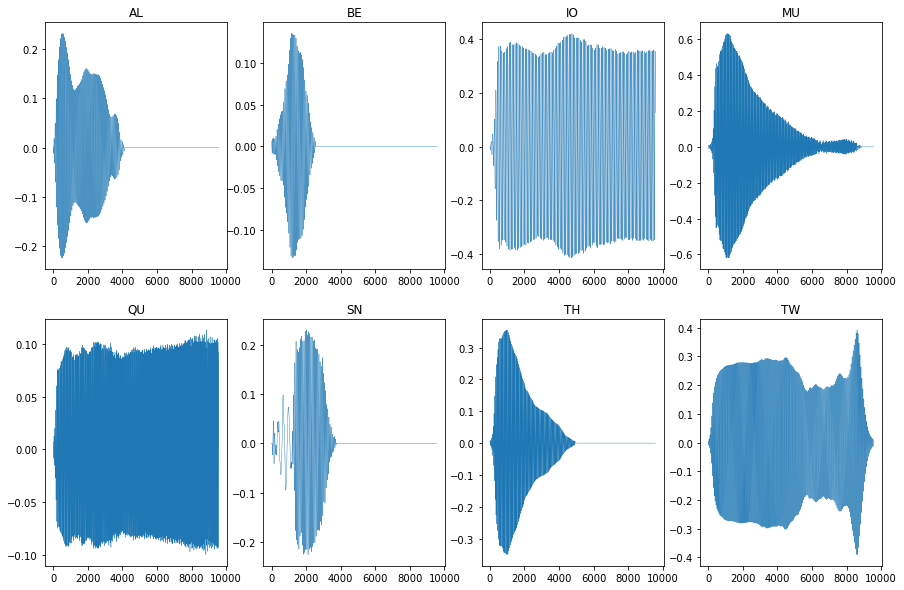

In [46]:
class LoadData(object):        
    def construct_dataframe(self):
        wfs = []
        labels = anno['class'].values.tolist()
        wavs = []


        for idx, data in anno.iterrows():
            path = f'data/{data.split}/{data.filename}'
            wf, _ = sf.read(path)
            wfs.append(wf)
            wavs.append(path)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        np.random.seed(42)
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

In [45]:
data_df.head()

Waveform  \
Category                                                        
0        0  [-0.001190185546875, -0.001861572265625, -0.00...   
         1  [0.00274658203125, 0.00201416015625, 0.0016784...   
         2  [-0.008514404296875, -0.00848388671875, -0.008...   
         3  [-0.00189208984375, -0.00128173828125, -0.0006...   
         4  [0.00555419921875, 0.005828857421875, 0.006103...   

                            Path Label  Category  
Category                                          
0        0  data/train/AL502.wav    AL         0  
         1  data/train/AL174.wav    AL         0  
         2  data/valid/AL480.wav    AL         0  
         3  data/train/AL905.wav    AL         0  
         4  data/train/AL630.wav    AL         0

Now that we have the raw data loaded, we can transform it into a shape and form that we will be able to build a DataLoader around.

In [54]:
WINDOW_WIDTH = mean_dur

In [55]:
X = np.zeros((len(data_df), WINDOW_WIDTH), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X[i, :] = wf
Y=data_df.Category.values
X.shape, Y.shape

((3744, 9570), (3744,))

Great! Now we have all the coo calls loaded into an array X with the associated identity labels Y. Next, we need to build our dataset of overlapping calls. In the [CPP perceptual playground notebook](http://localhost:2222/notebooks/Cocktail-Party-Problem/Perceptual-Integration-and-Segregation/Harmonicity.ipynb), we investigate some of the spectrotemporal acoustic cues that might enable the animal brain to solve the cocktail party problem. These include features such as harmonicity mistuning, onset/offset asynchrony, fundamental frequency f0 differencies, and frequency separation $\Delta f$, among others. While a thorough investigation might involve considering all these cues when constructing a synthetic dataset, for the purposes of this notebook, we'll construct a dataset as quickly as we can in order to get to the fun part: training the model!

To proceed with this proof-of-concept exploration, we'll combine 'BE' calls with 'QU' calls and 'SN' calls with 'TW' calls.

In [56]:
X_be, X_qu = X[Y == 1], X[Y == 4] 
X_sn, X_tw = X[Y == 5], X[Y == 7] 
X_be.shape, X_qu.shape, X_sn.shape, X_tw.shape

((468, 9570), (468, 9570), (468, 9570), (468, 9570))

In [57]:
X_bq = np.expand_dims(X_be+X_qu, axis=-1)
Y_be = np.expand_dims(X_be, axis=-1)
Y_qu = np.expand_dims(X_qu, axis=-1)
Y_bq = np.concatenate([Y_be, Y_qu], axis=-1)
X_bq.shape, Y_bq.shape

((468, 9570, 1), (468, 9570, 2))

In [58]:
X_st = np.expand_dims(X_sn+X_tw, axis=-1)
Y_sn = np.expand_dims(X_sn, axis=-1)
Y_tw = np.expand_dims(X_tw, axis=-1)
Y_st = np.concatenate([Y_sn, Y_tw], axis=-1)
X_st.shape, Y_st.shape

((468, 9570, 1), (468, 9570, 2))

In [59]:
X = np.concatenate([X_bq, X_st], axis=0)
Y = np.concatenate([Y_bq, Y_st], axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((748, 9570, 1), (188, 9570, 1), (748, 9570, 2), (188, 9570, 2))

From here on, it is just a matter of wrapping the data in PyTorch Datasets and subsequently PyTorch DataLoaders.

In [62]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, Xs, Ys):
        self.Xs = Xs
        self.Ys = Ys
        
    def __getitem__(self, index):
        return self.Xs[index], self.Ys[index]

    def __len__(self):
        return self.Xs.shape[0]

In [63]:
train_ds = Dataset(X_train, Y_train)
valid_ds = Dataset(X_test, Y_test)

In [66]:
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=multiprocessing.cpu_count()-1
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=2,
    shuffle=False,
    num_workers=multiprocessing.cpu_count()-1
)

In [67]:
batch = next(iter(train_dl))

In [70]:
batch[0].shape, batch[1].shape

(torch.Size([2, 9570, 1]), torch.Size([2, 9570, 2]))